In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def parse_fasta(file):
    genomes = {}
    with open(file, "r") as f:
        for line in f:
            line = line.replace('\n', '')
            if line.startswith(">"):
                curr = line
                genomes[curr] = ''
                continue
            genomes[curr] = genomes[curr] + line
    return genomes

genbank_fasta = 'mycovirus_genbank_all_refseq_nucleotide_unique.fasta'
Sclerotinia_fasta = 'Sclerotinia_biocontrol_mycovirus_nucleotide.fasta'
genbank = parse_fasta(genbank_fasta)
Sclerotinia = parse_fasta(Sclerotinia_fasta)

all_sequences = [genbank[a] for a in genbank] + [Sclerotinia[a] for a in Sclerotinia]

In [2]:
import time
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
np.random.seed(46)

In [43]:
# Interactive plot
%matplotlib qt

In [36]:
# stationary plot
%matplotlib inline

In [4]:
y = [0 for i in range(350)] + [1 for i in range(7)]
y = np.array(y)
print(y.shape)

(357,)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='char')
X = count_vect.fit_transform(all_sequences)
chars = count_vect.get_feature_names()

In [6]:
# 5-gram features generation
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer(analyzer='char',ngram_range=(5,6))
X = count_vect.fit_transform(all_sequences)
chars = count_vect.get_feature_names()
five_gram = X.toarray()
tf_transformer = TfidfTransformer(use_idf=True).fit(five_gram) #Enable inverse-document-frequency reweighting
five_gram_tf = tf_transformer.transform(five_gram)
five_gram_tf = five_gram_tf.toarray()

In [7]:
print(five_gram_tf.shape)

(357, 5529)


In [8]:
X = five_gram_tf
#np.random.shuffle(X)

In [9]:
df = pd.DataFrame(X)
df['y'] = y

In [10]:
df.shape

(357, 5530)

# PCA

In [11]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

In [12]:
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

In [13]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.13564258 0.05341059 0.03328983]


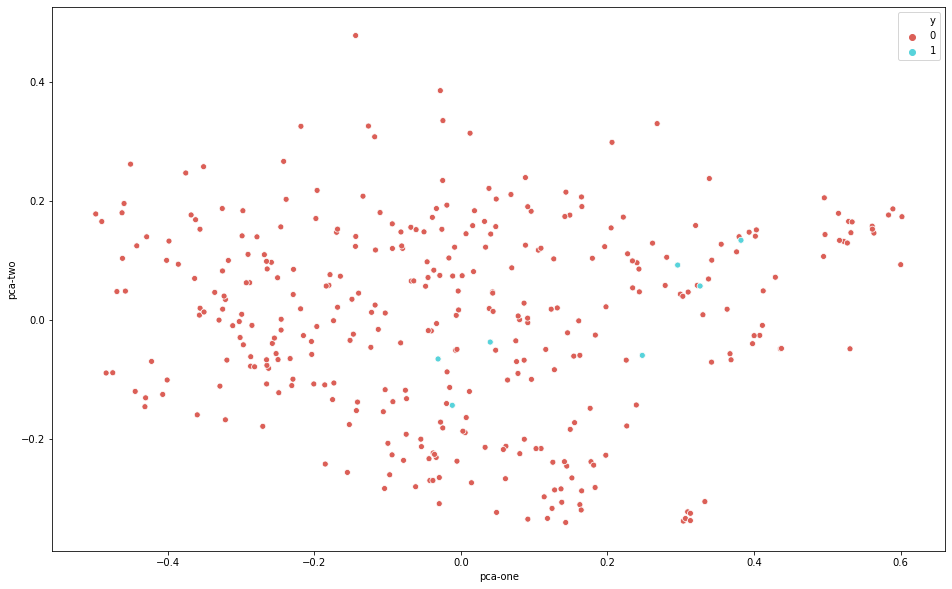

In [33]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

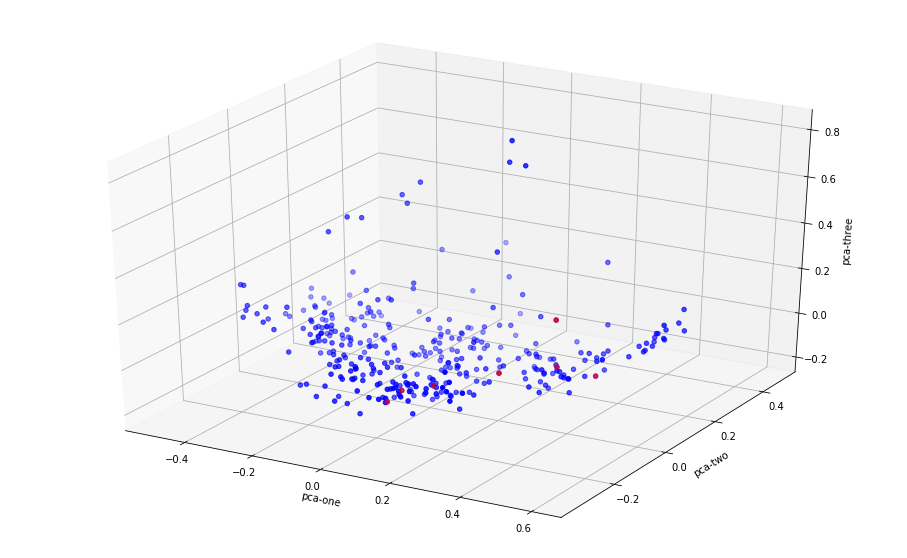

In [37]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='bwr'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# SVD

In [21]:
svd = TruncatedSVD(n_components=3, n_iter=20, random_state=46)
svd_5 = svd.fit_transform(X)

In [22]:
print(svd.explained_variance_ratio_.sum())

0.20378210025867805


In [23]:
print(svd_5.shape)
df['svd-one'] = svd_5[:,0]
df['svd-two'] = svd_5[:,1] 
df['svd-three'] = svd_5[:,2]

(357, 3)


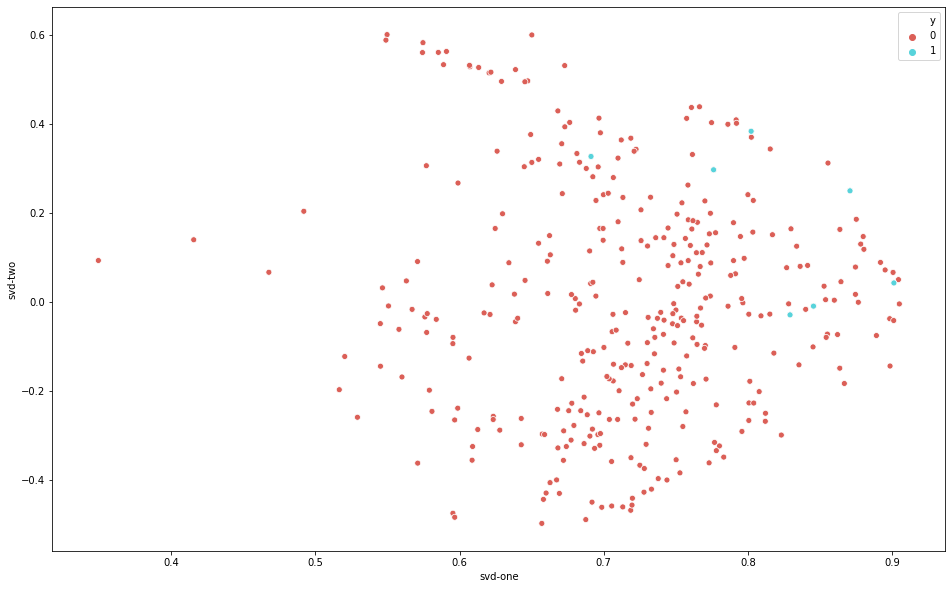

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

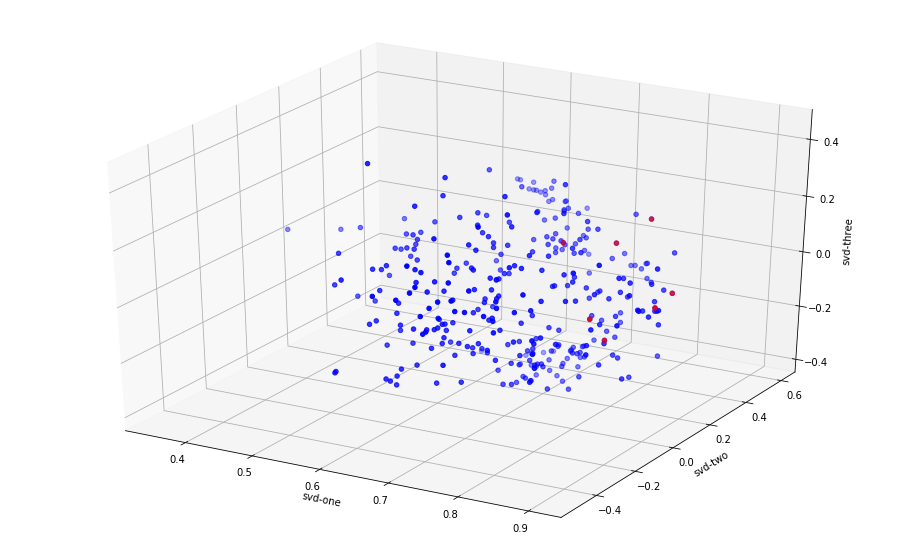

In [27]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["svd-one"], 
    ys=df["svd-two"], 
    zs=df["svd-three"], 
    c=df["y"], 
    cmap='bwr'
)
ax.set_xlabel('svd-one')
ax.set_ylabel('svd-two')
ax.set_zlabel('svd-three')
plt.show()

In [29]:
svd = TruncatedSVD(n_components=100, n_iter=20, random_state=46)
svd_100 = svd.fit_transform(X)
print(svd.explained_variance_ratio_.sum())

0.6672293223760173


In [38]:
pca = PCA(n_components=100)
pca_100 = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_.sum()))

Explained variation per principal component: 0.6639767167679077


In [30]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_svd_results = tsne.fit_transform(svd_100)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.006s...
[t-SNE] Computed neighbors for 357 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 0.217002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 136.672028
[t-SNE] KL divergence after 1000 iterations: 2.042075
t-SNE done! Time elapsed: 3.6679847240448 seconds


In [31]:
df['tsne-svd-1'] = tsne_svd_results[:,0]
df['tsne-svd-2'] = tsne_svd_results[:,1]
df['tsne-svd-3'] = tsne_svd_results[:,2]

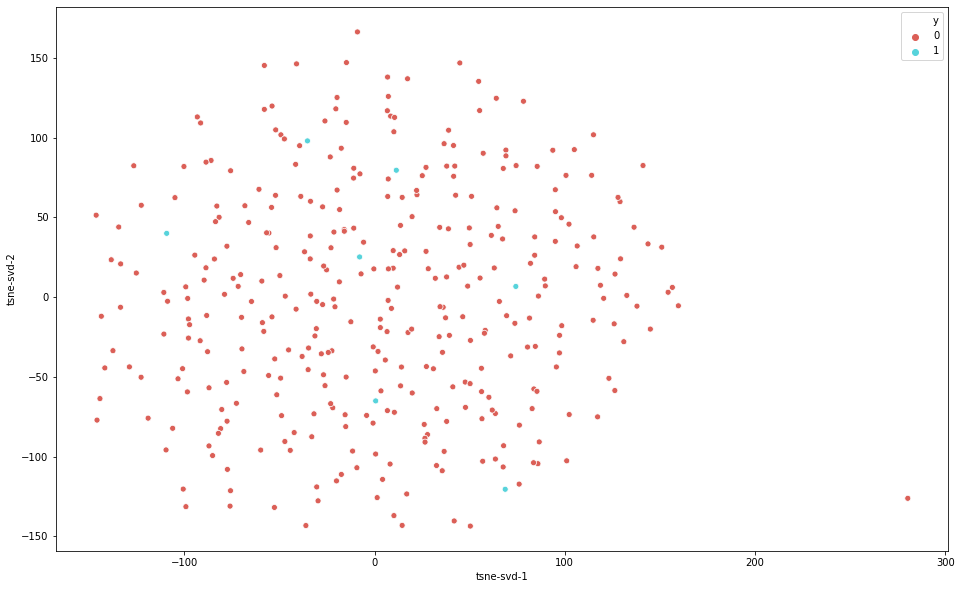

In [32]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-svd-1", y="tsne-svd-2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

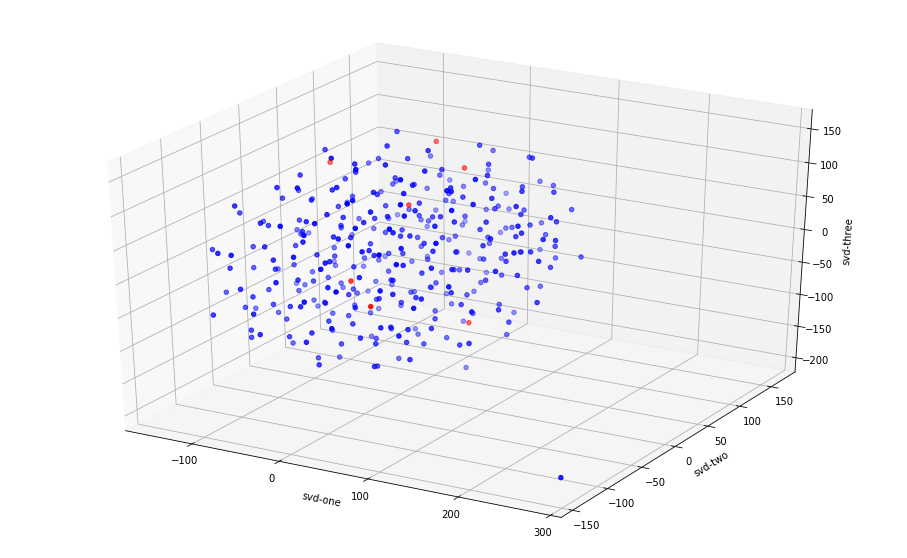

In [37]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["tsne-svd-1"], 
    ys=df["tsne-svd-2"], 
    zs=df["tsne-svd-3"], 
    c=df["y"], 
    cmap='bwr'
)
ax.set_xlabel('svd-one')
ax.set_ylabel('svd-two')
ax.set_zlabel('svd-three')
plt.show()

In [39]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=2000)
tsne_pca_results = tsne.fit_transform(pca_100)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.005s...
[t-SNE] Computed neighbors for 357 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 0.216375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 134.863373
[t-SNE] KL divergence after 2000 iterations: 1.672698
t-SNE done! Time elapsed: 6.132658243179321 seconds


In [40]:
df['tsne-pca-1'] = tsne_pca_results[:,0]
df['tsne-pca-2'] = tsne_pca_results[:,1]
df['tsne-pca-3'] = tsne_pca_results[:,2]

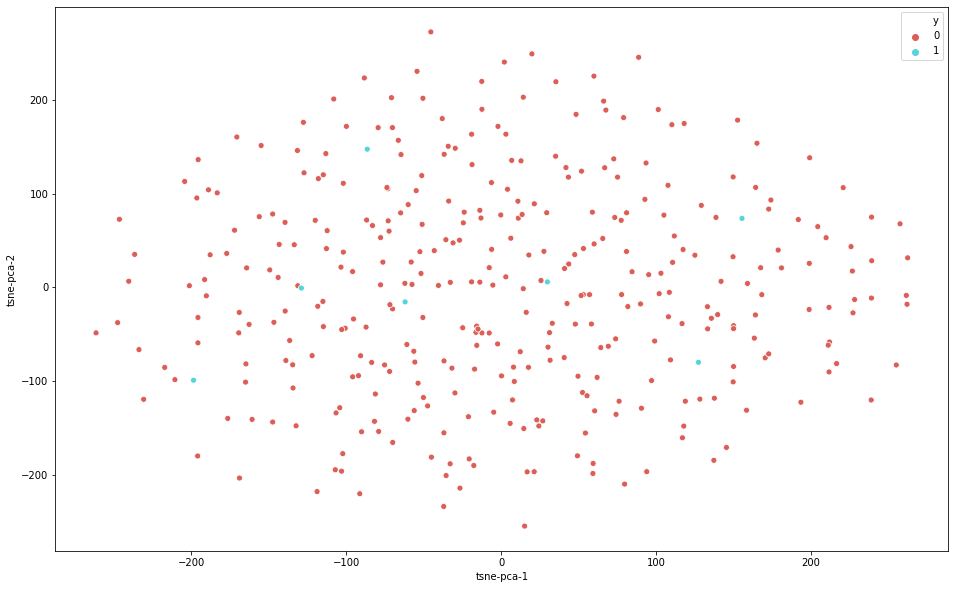

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-pca-1", y="tsne-pca-2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

In [44]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["tsne-pca-1"], 
    ys=df["tsne-pca-2"], 
    zs=df["tsne-pca-3"], 
    c=df["y"], 
    cmap='bwr'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Compare with the balanced dengue data 

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def parse_fasta(file):
    genomes = {}
    with open(file, "r") as f:
        for line in f:
            line = line.replace('\n', '')
            if line.startswith(">"):
                curr = line
                genomes[curr] = ''
                continue
            genomes[curr] = genomes[curr] + line
    return genomes

type_1_fa = 'dengue_1.fa'
type_2_fa = 'dengue_2.fa'
type_1 = parse_fasta(type_1_fa)
type_2 = parse_fasta(type_2_fa)

all_sequences = [type_1[a] for a in type_1] + [type_2[a] for a in type_2]
labels = np.array([0 for i in type_1] + [1 for i in type_2])
print(len(type_1))
print(len(type_2))
print(len(all_sequences))
len(labels)

2203
1702
3905


3905

In [82]:
count_vect = CountVectorizer(analyzer='char',ngram_range=(5,5))
X = count_vect.fit_transform(all_sequences)
chars = count_vect.get_feature_names()
five_gram = X.toarray()
tf_transformer = TfidfTransformer(use_idf=True).fit(five_gram) #Enable inverse-document-frequency reweighting
five_gram_tf = tf_transformer.transform(five_gram)
five_gram_tf = five_gram_tf.toarray()
print(five_gram_tf.shape)

(3905, 4565)


In [83]:
df = pd.DataFrame(five_gram_tf)
df['y'] = labels

In [84]:
svd = TruncatedSVD(n_components=3, n_iter=20, random_state=46)
svd_5 = svd.fit_transform(five_gram_tf)

In [85]:
print(svd.explained_variance_ratio_.sum())

0.5754330754316828


In [86]:
print(svd_5.shape)
df['svd-one'] = svd_5[:,0]
df['svd-two'] = svd_5[:,1] 
df['svd-three'] = svd_5[:,2]

(3905, 3)


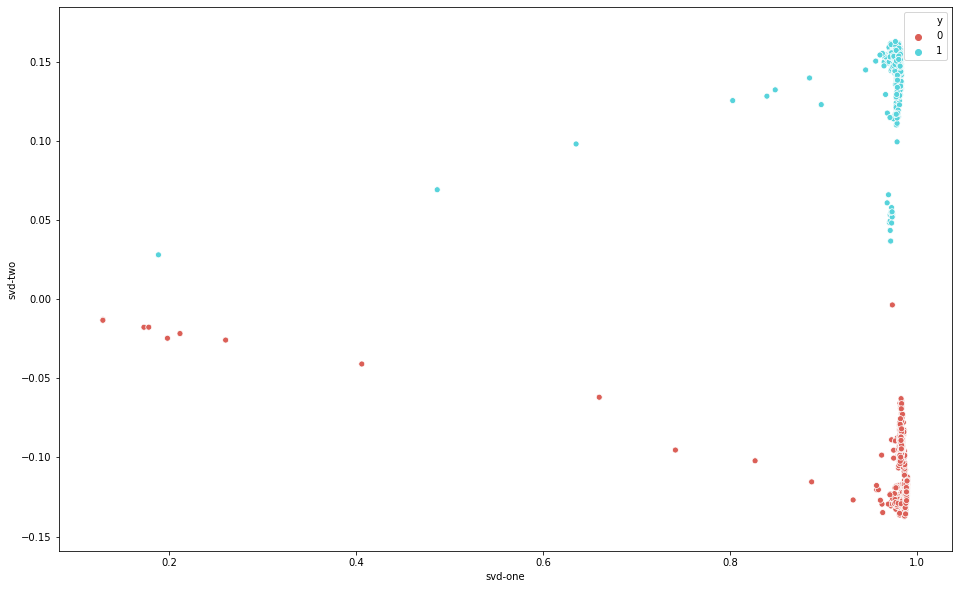

In [89]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

In [90]:
svd = TruncatedSVD(n_components=50, n_iter=20, random_state=46)
svd_50 = svd.fit_transform(five_gram_tf)
print(svd.explained_variance_ratio_.sum())

0.916219642960175


In [91]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_svd_results = tsne.fit_transform(svd_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3905 samples in 0.048s...
[t-SNE] Computed neighbors for 3905 samples in 0.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3905
[t-SNE] Computed conditional probabilities for sample 2000 / 3905
[t-SNE] Computed conditional probabilities for sample 3000 / 3905
[t-SNE] Computed conditional probabilities for sample 3905 / 3905
[t-SNE] Mean sigma: 0.011229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.254784
[t-SNE] KL divergence after 300 iterations: 0.685959
t-SNE done! Time elapsed: 11.773097276687622 seconds


In [92]:
df['tsne-svd-1'] = tsne_svd_results[:,0]
df['tsne-svd-2'] = tsne_svd_results[:,1]
df['tsne-svd-3'] = tsne_svd_results[:,2]

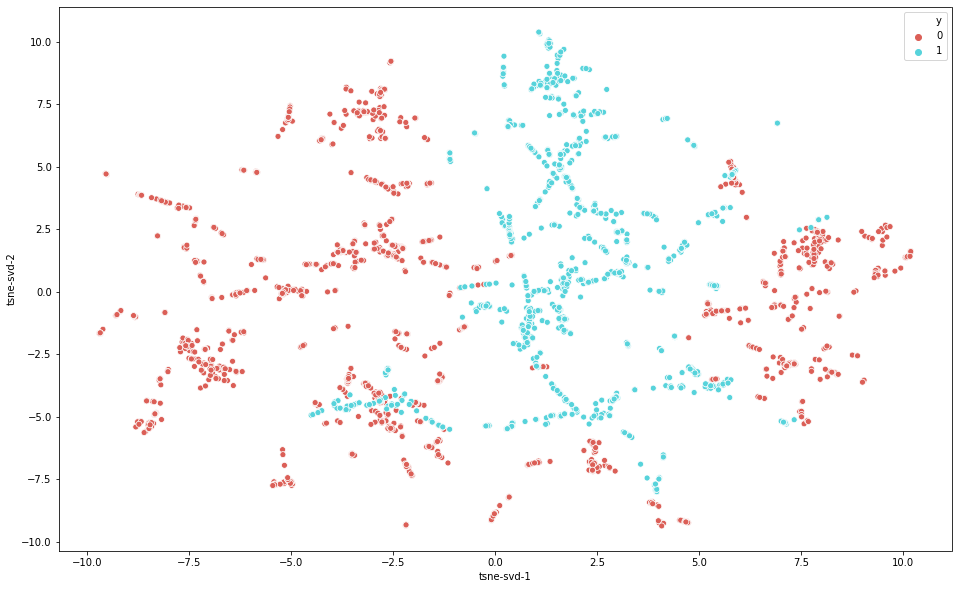

In [98]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-svd-1", y="tsne-svd-2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

# Compare with augmentated data

In [107]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [117]:
svd = TruncatedSVD(n_components=3, n_iter=20, random_state=46)
svd_5 = svd.fit_transform(X_resampled)

In [118]:
print(svd.explained_variance_ratio_.sum())

0.24059679139049697


In [119]:
df = pd.DataFrame(X_resampled)
df['y'] = y_resampled
df['svd-one'] = svd_5[:,0]
df['svd-two'] = svd_5[:,1] 
df['svd-three'] = svd_5[:,2]

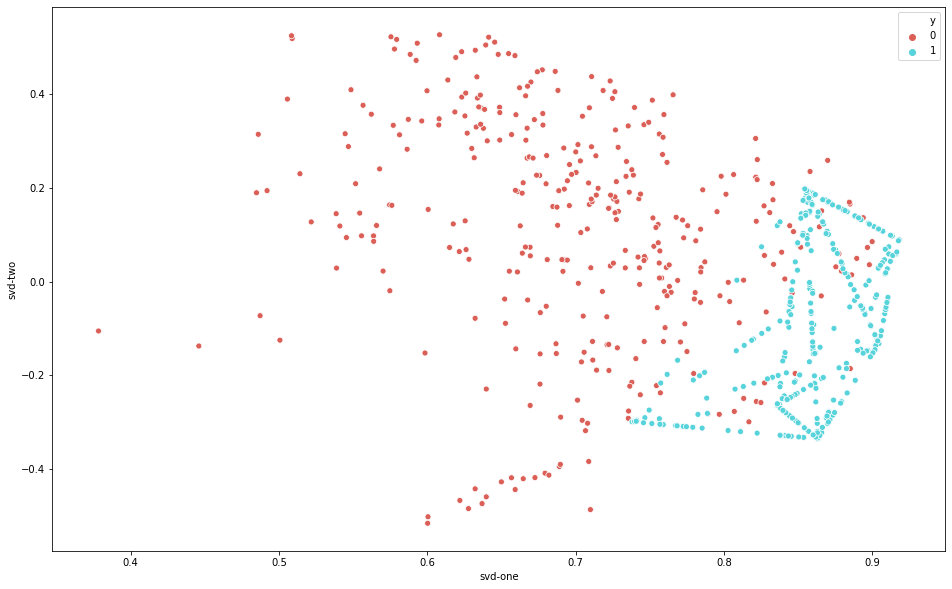

In [120]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)

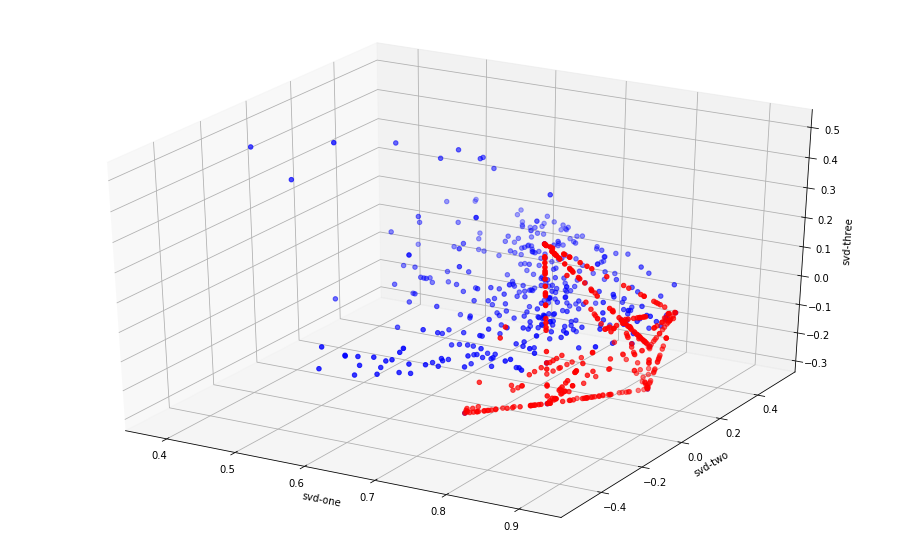

In [121]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["svd-one"], 
    ys=df["svd-two"], 
    zs=df["svd-three"], 
    c=df["y"], 
    cmap='bwr'
)
ax.set_xlabel('svd-one')
ax.set_ylabel('svd-two')
ax.set_zlabel('svd-three')
plt.show()

In [122]:
svd = TruncatedSVD(n_components=50, n_iter=20, random_state=46)
svd_50 = svd.fit_transform(X_resampled)
print(svd.explained_variance_ratio_.sum())

0.6496248865747827


In [123]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_svd_results = tsne.fit_transform(svd_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.007s...
[t-SNE] Computed neighbors for 700 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 0.176908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.984833
[t-SNE] KL divergence after 1000 iterations: 0.458119
t-SNE done! Time elapsed: 6.590387582778931 seconds


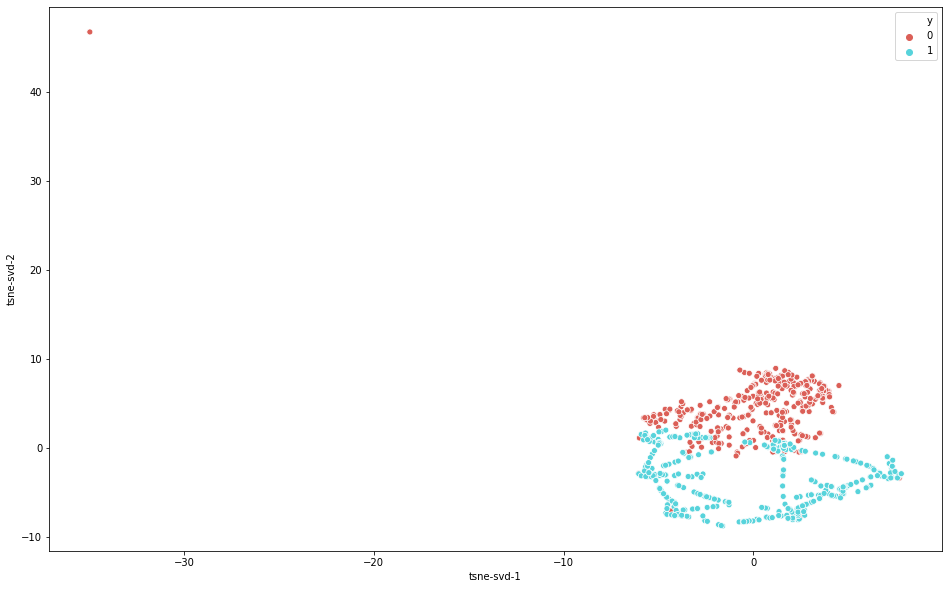

In [124]:
df['tsne-svd-1'] = tsne_svd_results[:,0]
df['tsne-svd-2'] = tsne_svd_results[:,1]
df['tsne-svd-3'] = tsne_svd_results[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-svd-1", y="tsne-svd-2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=1
)